1. [imgaug](https://github.com/aleju/imgaug)本文的项目路径
2. google-[Learning Data Augmentation Strategies for Object Detection](https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/detection/utils/autoaugment_utils.py)

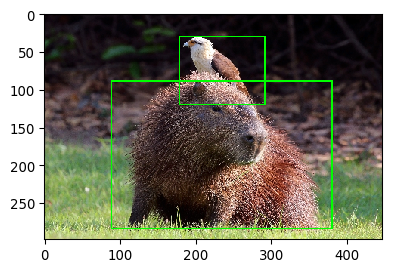

In [1]:
import imageio
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline
ia.seed(1)

image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/8/8e/Yellow-headed_caracara_%28Milvago_chimachima%29_on_capybara_%28Hydrochoeris_hydrochaeris%29.JPG")
image = ia.imresize_single_image(image, (298, 447))

bbs = BoundingBoxesOnImage([
    BoundingBox(x1=0.2*447, x2=0.85*447, y1=0.3*298, y2=0.95*298),
    BoundingBox(x1=0.4*447, x2=0.65*447, y1=0.1*298, y2=0.4*298)
], shape=image.shape)

ia.imshow(bbs.draw_on_image(image, size=2))

In [205]:
from imgaug import augmenters as iaa 
ia.seed(1)

模糊及噪声

In [907]:
 seq = iaa.Sequential([ 
     #iaa.OneOf([
     #               iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
     #               iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
     #               iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
     #           ]), #模糊
     #iaa.Sharpen(alpha=(0, 0.3), lightness=(0.5, 1.5)),  #锐化，亮度改变不明显
     #iaa.SimplexNoiseAlpha(iaa.OneOf([
     #               #iaa.EdgeDetect(alpha=(0.8, 1.0)), #亮度变化较单一，没有DirectedEdgeDetect效果好
     #               iaa.DirectedEdgeDetect(alpha=(0.3, 0.5), direction=(0.0, 1.0)), #图像变换较明显，主要体现在亮度
     #           ])),
     iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # 高斯噪声
     
 ])
    

颜色变化

In [1046]:
 seq = iaa.Sequential([
         #iaa.Invert(0.5, per_channel=True), # 一定比例交换通道顺序
         #iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
         #iaa.AddToHueAndSaturation((-50, 50)), #色调和饱和度
         iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
  ])


形状变化

In [518]:
seq = iaa.Sequential([
    #iaa.Fliplr(0.5), # 水平翻转
    #iaa.Flipud(0.01),  #上下翻转
    #iaa.CropAndPad(
    #        percent=(-0.05, 0.1), #依据图像宽高的[-5%, 10%]缩放，
    #        pad_mode=ia.ALL, #若数值过小则填充时会映射出roi区域
    #        pad_cval=(0, 255)
    #    )，
    #iaa.Affine(
    #        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # 原图缩放比例
    #        translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)}, # 平移比例
    #        rotate=(-5, 5), # 旋转角度，过大则会导致aug后的标注框过大
    #        #shear=(-16, 16), # 扭转角度，对刚体不可用
    #        order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)，插值方式
    #        cval=(0, 255), # if mode is constant, use a cval between 0 and 255
    #        mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
    #   ),
    iaa.PerspectiveTransform(scale=(0.1, 0.1)) #透视变换，对刚体不可用

])

BoundingBoxesOnImage([BoundingBox(x1=89.4000, y1=89.4000, x2=379.9500, y2=283.1000, label=None), BoundingBox(x1=178.8000, y1=29.8000, x2=290.5500, y2=119.2000, label=None)], shape=(298, 447, 3))


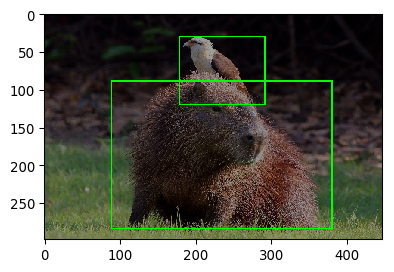

In [1074]:
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
print (bbs_aug)
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))

In [1094]:
seq = iaa.Sequential([
         iaa.DirectedEdgeDetect(alpha=(0.3, 0.4), direction=(0.0, 1.0)), #噪声
         iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),    #颜色
        iaa.Fliplr(0.5), # 水平翻转
        iaa.Flipud(0.01),  #上下翻转
        iaa.CropAndPad(
            percent=(-0.05, 0.1), #依据图像宽高的[-5%, 10%]缩放，
            pad_mode=ia.ALL, #若数值过小则填充时会映射出roi区域
            pad_cval=(0, 255)
        ),
        iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # 原图缩放比例
                translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)}, # 平移比例
                rotate=(-5, 5), # 旋转角度，过大则会导致aug后的标注框过大
                #shear=(-16, 16), # 扭转角度，对刚体不可用
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)，插值方式
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
           ),

])

BoundingBox(x1=70.2167, y1=89.4788, x2=376.1489, y2=288.6534, label=None) 199.17459063240307 305.93214994739355 70 89


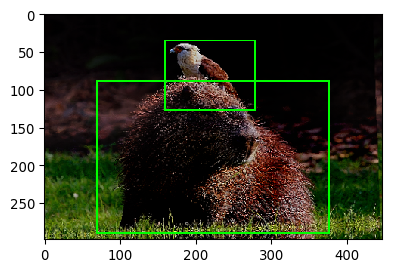

In [1123]:
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

print (bbs_aug.bounding_boxes[0],bbs_aug.bounding_boxes[0].height, bbs_aug.bounding_boxes[0].width, bbs_aug.bounding_boxes[0].x1_int,bbs_aug.bounding_boxes[0].y1_int)
ia.imshow(bbs_aug.draw_on_image(image_aug, size=2))